# MadMiner Parton-Level Analysis for $W\gamma$: Step 2 - Analysis

Johann Brehmer, Felix Kling, Kyle Cranmer 2018

In this tutorial we'll demonstrate how to use MadMiner to generate train and test samples for the Information Geometry methods introduced in the following papers:
- J. Brehmer, K. Cranmer, F. Kling, T. Plehn: ["Better Higgs Measurements Through Information Geometry"](https://arxiv.org/abs/1612.05261)
- J. Brehmer, F. Kling, T. Plehn, T.M.P. Tait: ["Better Higgs-CP Tests Through Information Geometry"](https://arxiv.org/abs/1712.02350)

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
% matplotlib inline

from madminer.fisherinformation import FisherInformation
from madminer.fisherinformation import project_information,profile_information

from madminer.plotting import plot_fisher_information_contours_2d
from madminer.plotting import plot_fisherinfo_barplot
from madminer.plotting import kinematic_distribution_of_information

from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge, EnsembleForge


## Define Input File sample

In [2]:
usename='1M'
nsamples=500000

useinputdata = 'data/madminer_wgamma_observables_'+usename+'.h5'
usesamplesdir = 'data/samples_'+usename+'/'
usemodelsdir = 'models/samples_'+usename+'/'

## 6. Make (unweighted) training and test samples with augmented data

In [3]:
#create sample augmenter
sa = SampleAugmenter(useinputdata, debug=False)
n_estimators = 5

#augment train sample
for i in range(n_estimators):
    x, theta, t_xz = sa.extract_samples_train_local(
        theta=constant_benchmark_theta('sm'),
        n_samples=nsamples,
        folder='./'+usesamplesdir,
        filename='train{}'.format(i)
    )

#augment test sample
x, theta = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=nsamples,
    folder='./'+usesamplesdir,
    filename='test'
)

18:45  
18:45  ------------------------------------------------------------
18:45  |                                                          |
18:45  |  MadMiner v2018.11.02                                    |
18:45  |                                                          |
18:45  |           Johann Brehmer, Kyle Cranmer, and Felix Kling  |
18:45  |                                                          |
18:45  ------------------------------------------------------------
18:45  
18:45  Loading data from data/madminer_wgamma_observables_1M.h5
18:45  Found 2 parameters:
18:45     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:45     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
18:45  Found 6 benchmarks:
18:45     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
18:45     w: CWL2 = 20.00, CPWL2 = 0.00e+00
18:45     morphing_basis_vector_2: CWL2 = 36.56, CPWL2 = -3.86e+01
18:45     morphing_basis_vector_3: CWL2 = -4.58e+01, CPWL2

## 7. Train a neural network to estimate the score

### 7a) Change Features

In [4]:
#NN Settings
n_hidden = (100,100)
n_epochs = 50
batch_size = 128
initial_lr=0.001
final_lr=0.0001
myfeatures=[(0,1,2,3,4,5,6,7,8),(0,1,2,3,4,5,6,7,8,9,10,11),(12,13,14,15,16,17,18,19,20,21,22),(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22)]
myfeaturename=["mom","enmom","high","all"]

#Run NN
for ii in range(len(myfeatures)):
    #Setup ensemble
    ensemble = EnsembleForge(estimators=n_estimators)
    #train ensemble
    ensemble.train_all(
        method='sally',
        x_filename=[usesamplesdir+'x_train{}.npy'.format(i) for i in range(n_estimators)],
        t_xz0_filename=[usesamplesdir+'t_xz_train{}.npy'.format(i) for i in range(n_estimators)],
        n_epochs=n_epochs,
        batch_size=batch_size,
        validation_split=None,
        n_hidden=n_hidden,
        initial_lr=initial_lr,
        final_lr=final_lr,
        features=myfeatures[ii]
    )
    #save ensemble
    ensemble.save(usemodelsdir+'sally_ensemble_{}'.format(myfeaturename[ii]))

18:45  Training 5 estimators in ensemble
18:45  Training estimator 1 / 5 in ensemble
18:45  Starting training
18:45    Method:                 sally
18:45    Training data: x at data/samples_1M/x_train0.npy
18:45                   t_xz (theta0) at  data/samples_1M/t_xz_train0.npy
18:45    Features:               (0, 1, 2, 3, 4, 5, 6, 7, 8)
18:45    Method:                 sally
18:45    Hidden layers:          (100, 100)
18:45    Activation function:    tanh
18:45    Batch size:             128
18:45    Trainer:                amsgrad
18:45    Epochs:                 50
18:45    Learning rate:          0.001 initially, decaying to 0.0001
18:45    Validation split:       None
18:45    Early stopping:         True
18:45    Scale inputs:           True
18:45  Loading training data
18:45  Found 500000 samples with 2 parameters and 23 observables
18:45  Rescaling inputs
18:45  Only using 9 of 23 observables
18:45  Creating model for method sally
18:45  Training model
18:46    Epoch 5: train

19:19  Rescaling inputs
19:19  Only using 12 of 23 observables
19:19  Creating model for method sally
19:19  Training model
19:20    Epoch 5: train loss 0.00 ([0.00239178])
19:20    Epoch 10: train loss 0.00 ([0.00227984])
19:21    Epoch 15: train loss 0.00 ([0.00221716])
19:22    Epoch 20: train loss 0.00 ([0.00217251])
19:22    Epoch 25: train loss 0.00 ([0.00213982])
19:23    Epoch 30: train loss 0.00 ([0.00211575])
19:24    Epoch 35: train loss 0.00 ([0.0020966])
19:24    Epoch 40: train loss 0.00 ([0.00208159])
19:25    Epoch 45: train loss 0.00 ([0.00207086])
19:26    Epoch 50: train loss 0.00 ([0.00206111])
19:26  Finished training
19:26  Training estimator 2 / 5 in ensemble
19:26  Starting training
19:26    Method:                 sally
19:26    Training data: x at data/samples_1M/x_train1.npy
19:26                   t_xz (theta0) at  data/samples_1M/t_xz_train1.npy
19:26    Features:               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)
19:26    Method:                 sally
19

19:59                   t_xz (theta0) at  data/samples_1M/t_xz_train1.npy
19:59    Features:               (12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)
19:59    Method:                 sally
19:59    Hidden layers:          (100, 100)
19:59    Activation function:    tanh
19:59    Batch size:             128
19:59    Trainer:                amsgrad
19:59    Epochs:                 50
19:59    Learning rate:          0.001 initially, decaying to 0.0001
19:59    Validation split:       None
19:59    Early stopping:         True
19:59    Scale inputs:           True
19:59  Loading training data
19:59  Found 500000 samples with 2 parameters and 23 observables
19:59  Rescaling inputs
19:59  Only using 11 of 23 observables
19:59  Creating model for method sally
19:59  Training model
20:00    Epoch 5: train loss 0.00 ([0.00200103])
20:01    Epoch 10: train loss 0.00 ([0.00190193])
20:02    Epoch 15: train loss 0.00 ([0.00185561])
20:02    Epoch 20: train loss 0.00 ([0.00182967])
20:03    Epoc

20:34  Creating model for method sally
20:34  Training model
20:34    Epoch 5: train loss 0.00 ([0.00195135])
20:35    Epoch 10: train loss 0.00 ([0.00184477])
20:36    Epoch 15: train loss 0.00 ([0.00178846])
20:36    Epoch 20: train loss 0.00 ([0.00174765])
20:37    Epoch 25: train loss 0.00 ([0.00171169])
20:38    Epoch 30: train loss 0.00 ([0.00168886])
20:38    Epoch 35: train loss 0.00 ([0.00166613])
20:39    Epoch 40: train loss 0.00 ([0.00164997])
20:40    Epoch 45: train loss 0.00 ([0.00163507])
20:40    Epoch 50: train loss 0.00 ([0.0016261])
20:40  Finished training
20:40  Training estimator 3 / 5 in ensemble
20:40  Starting training
20:40    Method:                 sally
20:40    Training data: x at data/samples_1M/x_train2.npy
20:40                   t_xz (theta0) at  data/samples_1M/t_xz_train2.npy
20:40    Features:               (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)
20:40    Method:                 sally
20:40    Hidden layer

## 8. FisherInfo for Processed Data

In [5]:
#Setup MadFisher
fisher = FisherInformation(useinputdata, debug=False)

#Run MadFisher
fi_det_mean_all, fi_det_cov_all = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,return_error=True,
    model_file=usemodelsdir+'sally_ensemble_all',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)
fi_det_mean_high, fi_det_cov_high = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,return_error=True,
    model_file=usemodelsdir+'sally_ensemble_high',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)
fi_det_mean_mom, fi_det_cov_mom = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,return_error=True,
    model_file=usemodelsdir+'sally_ensemble_mom',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)
fi_det_mean_enmom, fi_det_cov_enmom = fisher.calculate_fisher_information_full_detector(
    theta=[0.,0.], luminosity=300*1000.,return_error=True,
    model_file=usemodelsdir+'sally_ensemble_enmom',
    unweighted_x_sample_file=usesamplesdir+'x_test.npy'
)

#Run MadFisher Truth
fi_pl_full,_ = fisher.calculate_fisher_information_full_truth(theta=[0.,0.],luminosity=300*1000.)

21:01  Loading data from data/madminer_wgamma_observables_1M.h5
21:01  Found 2 parameters:
21:01     CWL2 (LHA: dim6 2, maximal power in squared ME: (2,), range: (-50.0, 50.0))
21:01     CPWL2 (LHA: dim6 5, maximal power in squared ME: (2,), range: (-50.0, 50.0))
21:01  Found 6 benchmarks:
21:01     sm: CWL2 = 0.00e+00, CPWL2 = 0.00e+00
21:01     w: CWL2 = 20.00, CPWL2 = 0.00e+00
21:01     morphing_basis_vector_2: CWL2 = 36.56, CPWL2 = -3.86e+01
21:01     morphing_basis_vector_3: CWL2 = -4.58e+01, CPWL2 = 36.32
21:01     morphing_basis_vector_4: CWL2 = -4.60e+01, CPWL2 = -4.27e+01
21:01     morphing_basis_vector_5: CWL2 = -1.92e+00, CPWL2 = 45.53
21:01  Found 23 observables: px_l, px_v, px_a, py_l, py_v, py_a, pz_l, pz_v, pz_a, e_l, e_v, e_a, pt_l, pt_v, pt_a, eta_l, eta_v, eta_a, dphi_lv, dphi_la, dphi_va, m_lv, m_lva
21:01  Found 1000000 events
21:01  Found morphing setup with 6 components
21:03  Found ensemble with 5 estimators and expectations None
21:03  Evaluating Fisher informat

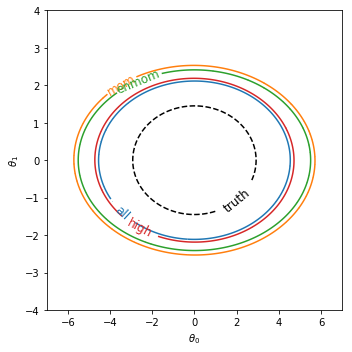

In [6]:
#Plot FisherInfo
fignn = plot_fisher_information_contours_2d(
    [fi_det_mean_all,fi_det_mean_mom,fi_det_mean_enmom,fi_det_mean_high, fi_pl_full],
    [fi_det_cov_all ,fi_det_cov_mom ,fi_det_cov_enmom ,fi_det_cov_high , None      ],
    colors=[u'C0',u'C1',u'C2',u'C3',"black"],
    linestyles=["solid","solid","solid","solid","dashed"],
    inline_labels=["all","mom","enmom","high","truth"],
    xrange=(-7.,7.),
    yrange=(-4.,4.),
)